In [1]:
import numpy as np
import scipy
import librosa
import IPython
import matplotlib.pyplot as plt
from scipy.io import wavfile

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_fft(fft_data, size=400):
    '''
    画傅立叶变换的三维图形
    '''
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make the grid
    x, y, z = np.meshgrid(np.arange(0, size, 1),
                          np.array([0]),
                          np.array([0]))
    size = x.shape[1]
    x = x.reshape(np.product(x.shape))
    y = y.reshape(np.product(y.shape))
    z = z.reshape(np.product(z.shape))
    # print(x,y,z)


    # Make the direction data for the arrows
    u = np.zeros_like(x)
    v = fft_data.imag[:size]
    w = fft_data.real[:size]
    lengths = abs(fft_data)[:size] / 1000

    for x1,y1,z1,u1,v1,w1,l in zip(x,y,z,u,v,w,lengths):
        ax.quiver(x1,y1,z1,u1,v1,w1, length=l, normalize=True)
    ax.plot([-10,410], [0,0], [0,0], c='r')
    plt.show()

In [3]:
def istf_overlap_add(stft_matrix, n_fft=2048, win_length=None, hop_length=None):
    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)
        
    n_frames = stft_matrix.shape[1]
    ifft_window = librosa.filters.get_window('hann', win_length, fftbins=True)

    expected_signal_len = n_fft + hop_length * (n_frames - 1)
    y = np.zeros(expected_signal_len, dtype=np.float32)

    for i in range(n_frames):
        sample = i * hop_length
        spec = stft_matrix[:, i].flatten()
        spec = np.concatenate((spec, spec[-2:0:-1].conj()), 0)
        ytmp = scipy.fftpack.ifft(spec).real

        y[sample:(sample + n_fft)] = y[sample:(sample + n_fft)] + ytmp
        
    y = y[int(n_fft // 2):-int(n_fft // 2)] /2
    return y

In [4]:
def griffin_lim(stftm_matrix, shape, use_OA=False, min_iter=20, max_iter=50, delta=20):
    '''
    根据频谱幅度重建信号
    '''
    y = np.random.random(shape)
    y_iter = []

    for i in range(max_iter):
        if i >= min_iter and (i - min_iter) % delta == 0:
            y_iter.append((y, i))
        stft_matrix = librosa.core.stft(y)
#         plot_fft(stft_matrix[:,2])
        stft_matrix = stftm_matrix * stft_matrix / np.abs(stft_matrix)
#         plot_fft(stft_matrix[:,2])
        if use_OA:
            y = istf_overlap_add(stft_matrix)
        else:
            y = librosa.core.istft(stft_matrix)
    y_iter.append((y, max_iter))

    return y_iter

## 加噪声的复频域复原信号

In [5]:
data, sr = librosa.core.load('lj.wav', sr=16000)
stft_matrix = librosa.core.stft(data) 

# 在复频域加入噪声
random_real = np.random.random(stft_matrix.shape)
random_imag = np.random.random(stft_matrix.shape)
random_complex = [[complex(0,0)] * stft_matrix.shape[1] for i in range(stft_matrix.shape[0])]
random_complex = np.array(random_complex)
for i in range(random_complex.shape[0]):
    for j in range(random_complex.shape[1]):
        random_complex[i][j] = np.complex(random_real[i][j], random_imag[i][j])

stft_matrix_modified = stft_matrix + random_complex

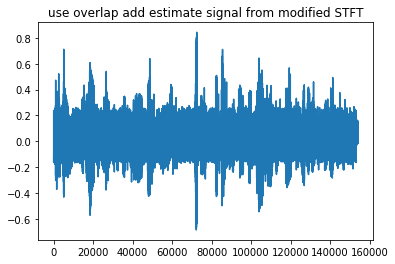

In [6]:
# overlap add方法
y = istf_overlap_add(stft_matrix_modified)
plt.figure()
plt.title('use overlap add estimate signal from modified STFT')
plt.plot(y)
IPython.display.Audio(y, rate=16000)

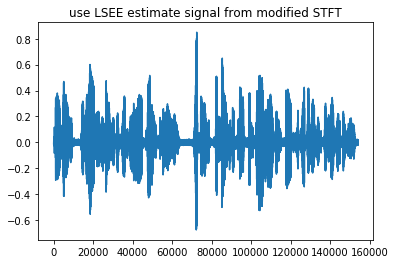

In [7]:
# griffin lim提出的方法
y = librosa.core.istft(stft_matrix_modified)
plt.figure()
plt.title('use LSEE estimate signal from modified STFT')
plt.plot(y)
IPython.display.Audio(y, rate=16000)

## 频谱（只有幅度信息，没有相位信息）复原信号

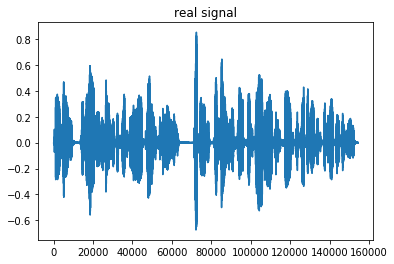

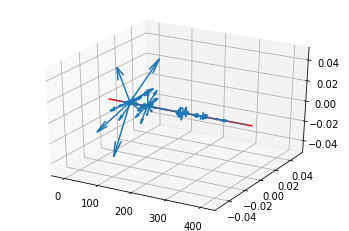

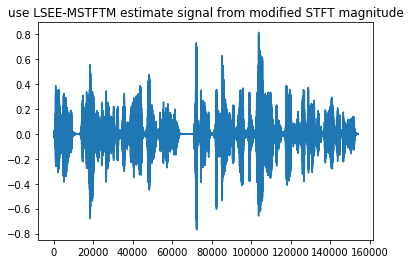

In [8]:
# assume 1 channel wav file
n_fft = 2048
data, sr = librosa.core.load('lj.wav', sr=16000)

plt.figure()
plt.title('real signal')
plt.plot(data)

# 由 STFT -> STFT magnitude
stftm_matrix = np.abs(librosa.core.stft(data))

plot_fft(librosa.core.stft(data)[:,2])
# + random 模拟 modification
stftm_matrix_modified = stftm_matrix #+ np.random.random(stftm_matrix.shape)

# Griffin-Lim 估计音频信号,使用LSEE-MSTFTM
y_iters = griffin_lim(stftm_matrix_modified, data.shape)
plt.figure()
plt.title('use LSEE-MSTFTM estimate signal from modified STFT magnitude')
plt.plot(y_iters[-1][0])
IPython.display.Audio(y_iters[-1][0], rate=16000)

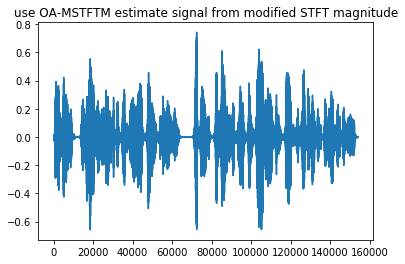

In [9]:
# Griffin-Lim 估计音频信号,使用OA-MSTFTM
y_iters = griffin_lim(stftm_matrix_modified, data.shape, use_OA=True)
plt.figure()
plt.title('use OA-MSTFTM estimate signal from modified STFT magnitude')
plt.plot(y_iters[-1][0])
IPython.display.Audio(y_iters[-1][0], rate=16000)